In [1]:
import sys 
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchmetrics import MeanSquaredError
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import pandas as pd
import random
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error, top_k_accuracy_score
from torchmetrics.functional import r2_score as r2_loss
from sklearn.model_selection import train_test_split
from itertools import product

from torch.utils.data import DataLoader, TensorDataset

sys.path.append(os.path.dirname(os.getcwd())) 
from source.autoencoder import VariationalAutoencoder, Autoencoder

In [2]:
df = pd.read_csv('../data/ba_interval_dataset_7200.csv', 
                 index_col=0).iloc[:,:155]
df

,beta,gamma,delta,init_inf_frac,alpha,incidence_0,incidence_1,incidence_2,incidence_3,incidence_4,...,incidence_140,incidence_141,incidence_142,incidence_143,incidence_144,incidence_145,incidence_146,incidence_147,incidence_148,incidence_149
0,0.10,0.3,0.2,0.0001,0.20,0.0,7.8,20.1,22.4,26.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10,0.3,0.2,0.0001,0.21,0.0,10.1,23.5,28.9,32.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.3,0.2,0.0001,0.22,0.0,11.5,22.9,30.5,30.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.10,0.3,0.2,0.0001,0.23,0.0,8.4,22.2,32.3,31.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.10,0.3,0.2,0.0001,0.24,0.0,12.4,25.5,30.5,31.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.99,0.3,0.2,0.0001,0.95,0.0,539.2,1500.4,2994.9,5383.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7196,0.99,0.3,0.2,0.0001,0.96,0.0,596.6,1653.8,3445.3,6255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7197,0.99,0.3,0.2,0.0001,0.97,0.0,614.8,1833.0,3967.9,7235.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7198,0.99,0.3,0.2,0.0001,0.98,0.0,645.0,2087.0,4727.1,8582.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
network_type = 'ba' # ba for Barabasi-Albert network, sw for small world network
df = pd.read_csv('../data/ba_interval_dataset_7200.csv', 
                 index_col=0).iloc[:,:155]
df
tmax = df.values.shape[1] - 5 # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[['incidence_'+str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]
print(r'Диапазон параметров beta:[{}, {}], alpha:[{}, {}]'.format(round(df['beta'].min(), 2), 
                                                                  round(df['beta'].max(), 2),
                                                                  round(df['alpha'].min(), 2),
                                                                  round(df['alpha'].max(), 2)))

Диапазон параметров beta:[0.1, 0.99], alpha:[0.2, 0.99]


In [4]:
data

,beta,alpha,ts
0,0.10,0.20,"[0.0, 7.8, 20.1, 22.4, 26.3, 24.5, 22.4, 21.8,..."
1,0.10,0.21,"[0.0, 10.1, 23.5, 28.9, 32.2, 33.0, 27.3, 27.9..."
2,0.10,0.22,"[0.0, 11.5, 22.9, 30.5, 30.5, 32.1, 26.8, 22.4..."
3,0.10,0.23,"[0.0, 8.4, 22.2, 32.3, 31.7, 28.2, 28.4, 25.3,..."
4,0.10,0.24,"[0.0, 12.4, 25.5, 30.5, 31.9, 31.2, 25.0, 29.8..."
...,...,...,...
7195,0.99,0.95,"[0.0, 539.2, 1500.4, 2994.9, 5383.4, 8403.0, 1..."
7196,0.99,0.96,"[0.0, 596.6, 1653.8, 3445.3, 6255.0, 9483.8, 1..."
7197,0.99,0.97,"[0.0, 614.8, 1833.0, 3967.9, 7235.0, 10682.9, ..."
7198,0.99,0.98,"[0.0, 645.0, 2087.0, 4727.1, 8582.9, 12094.8, ..."


In [5]:
X = data.drop(columns=['ts'])#[['file']]
y = data['ts']

X_train, X_test = train_test_split(X, test_size=2400, 
                                   random_state=42, stratify=None)
y_train = y.loc[X_train.index].values
y_test = y.loc[X_test.index].values

X_train, X_test = X_train.values, X_test.values

# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)


In [6]:

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Autoencoder

In [7]:
def loss(criterion, pred, gt):
    loss = criterion(pred, gt)
    return loss

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            
            loss = criterion(pred, y_batch.to(device))

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

In [8]:
def train(
    model,
    n_epochs,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler=None,
    patience=5,
    delta=0,
    device='cpu'
):
    best_loss = float('inf')
    counter = 0
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            loss = criterion(pred, y_batch.to(device))
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation on test/validation set
        model.eval()
        test_total_loss = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                pred_test = model(X_test.to(device))
                loss_test = criterion(pred_test, y_test.to(device))
                test_total_loss += loss_test.item()

        avg_test_loss = test_total_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}, Train loss: {avg_train_loss:.4f}, Test loss: {avg_test_loss:.4f}")

        #if avg_test_loss < 3300:
        #    break

        # Early stopping logic
        # if avg_train_loss < best_loss - delta:
        #     best_loss = avg_train_loss
        #     counter = 0
        # else:
        #     counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break
    return train_losses, test_losses


#### Grid search for best hiddens_size and latent_size

In [12]:
from itertools import product

mse_cr = F.mse_loss
r2_cr = r2_loss

# Define grid ranges
hidden_sizes = [16, 32, 64, 128, 256]               # Example values; adjust as needed
latent_sizes = [16, 32, 64, 128, 256]                 # Example values; adjust as needed

results = []

# for hidden_size, latent_size in product(hidden_sizes, latent_sizes):
#     print(f"Testing hidden_size={hidden_size}, latent_size={latent_size}")
    
#     # Initialize new model for each combo
#     model = Autoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    
#     # You must re-create your DataLoader objects if your data depends on model params
#     # train_loader, test_loader = ...
  
#     # Train model
#     train_losses, test_losses = train(
#         model=model,
#         n_epochs=50,   # reduce for faster search, or keep as n_epochs
#         train_loader=train_loader,
#         test_loader=test_loader,
#         criterion=mse_cr,
#         optimizer=optimizer,
#         scheduler=None,      # or your scheduler if needed
#         patience=5,
#         delta=0,
#         device=device
#     )
#     # Evaluate performance (last test loss, or min/avg as you wish)
#     best_test_loss = min(test_losses)
#     results.append({
#         'hidden_size': hidden_size,
#         'latent_size': latent_size,
#         'test_loss': best_test_loss
#     })

# # Find best combination
# best_config = min(results, key=lambda x: x['test_loss'])
# print("Best config:", best_config)

# # To display all results
# for res in results:
#     print(res)

#### AE train

In [9]:
hidden_size = 256
latent_size = 32
n_epochs = 100

mse_cr = F.mse_loss
r2_cr = r2_loss
ae = Autoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=5e-4)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

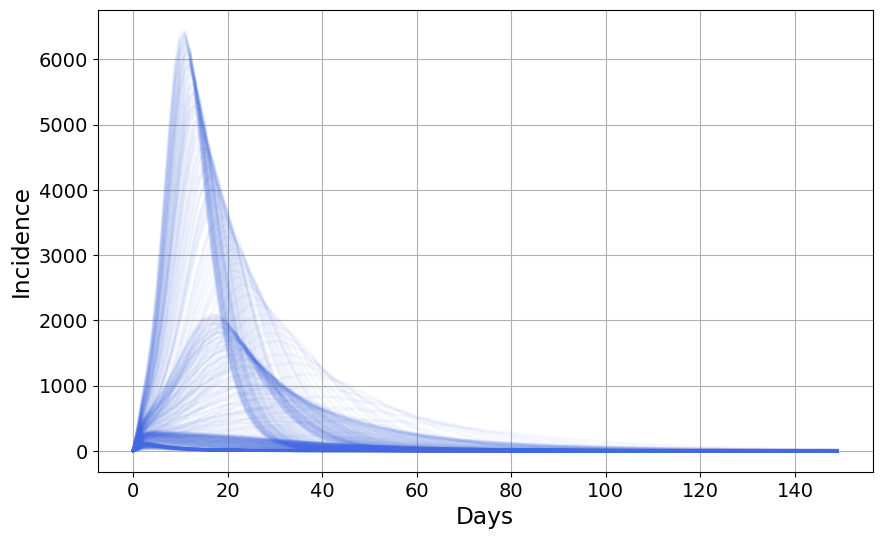

In [10]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(0, len(data), 20):
    ax.plot(data.values[i][2], lw='2', color='RoyalBlue', alpha=0.05)
ax.set_xlabel('Days', fontsize=1.2*fontsize)
ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.legend(fontsize=1.2*fontsize)
ax.grid()


In [11]:

train_losses, test_losses = train(model=ae,
        n_epochs=100,   # reduce for faster search, or keep as n_epochs
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=mse_cr,
        optimizer=optimizer,
        scheduler=None,      # or your scheduler if needed
        patience=5,
        delta=0,
        device=device)

Epoch 1, Train loss: 329867.0373, Test loss: 196029.2529
Epoch 2, Train loss: 104939.2615, Test loss: 55590.6344
Epoch 3, Train loss: 51218.9567, Test loss: 44770.9371
Epoch 4, Train loss: 35074.6676, Test loss: 27709.4015
Epoch 5, Train loss: 22904.6592, Test loss: 26827.2152
Epoch 6, Train loss: 16569.8893, Test loss: 18439.6455
Epoch 7, Train loss: 13628.0454, Test loss: 14225.4555
Epoch 8, Train loss: 12325.1809, Test loss: 10204.3773
Epoch 9, Train loss: 10222.0646, Test loss: 9048.4022
Epoch 10, Train loss: 9399.6327, Test loss: 7534.1223
Epoch 11, Train loss: 7709.3463, Test loss: 11006.0732
Epoch 12, Train loss: 6574.5728, Test loss: 5915.8650
Epoch 13, Train loss: 6239.7180, Test loss: 4443.4480
Epoch 14, Train loss: 5590.4346, Test loss: 4339.5455
Epoch 15, Train loss: 4198.0276, Test loss: 3408.4549
Epoch 16, Train loss: 4110.0069, Test loss: 7412.9552
Epoch 17, Train loss: 3523.6546, Test loss: 3219.6097
Epoch 18, Train loss: 3517.8034, Test loss: 3675.1326
Epoch 19, Train 

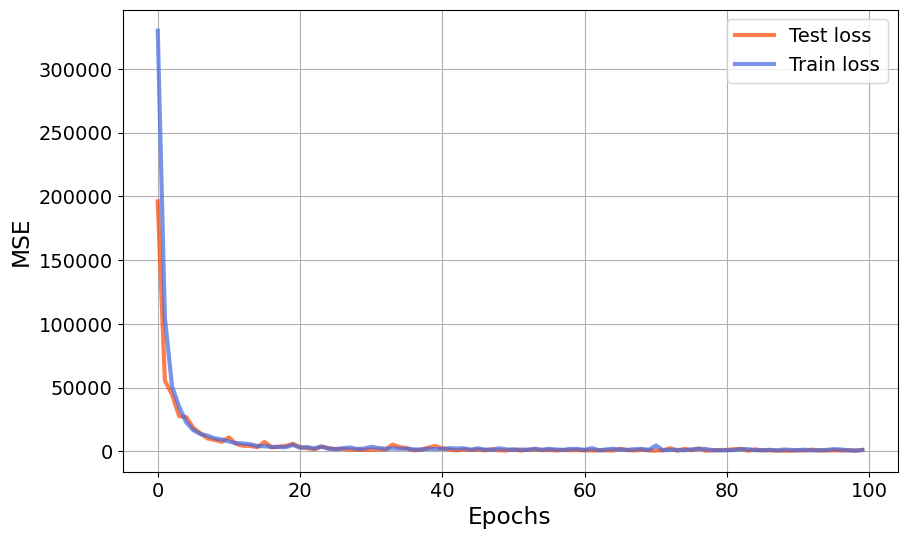

In [12]:
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_losses, lw=3, label='Test loss', color='OrangeRed', alpha=0.7)
ax.plot(train_losses, lw=3, label='Train loss', color='RoyalBlue', alpha=0.7)
ax.set_xlabel('Epochs', fontsize=1.2*fontsize)
ax.set_ylabel('MSE', fontsize=1.2*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid()

In [13]:
test(ae, X_test, y_test)

R2 Score: 0.7901828436305126


In [14]:
torch.save(ae, '../models/autoencoder_barabasi_100k_mean_n.pt')

#### AE save/load model

In [15]:
# Saving
# torch.save(ae, '../models/autoencoder.pt')

# Loading
ae = torch.load('../models/autoencoder_barabasi_100k_mean_n.pt', weights_only=False)
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=150, bias=True)
  )
)

#### AE subplots

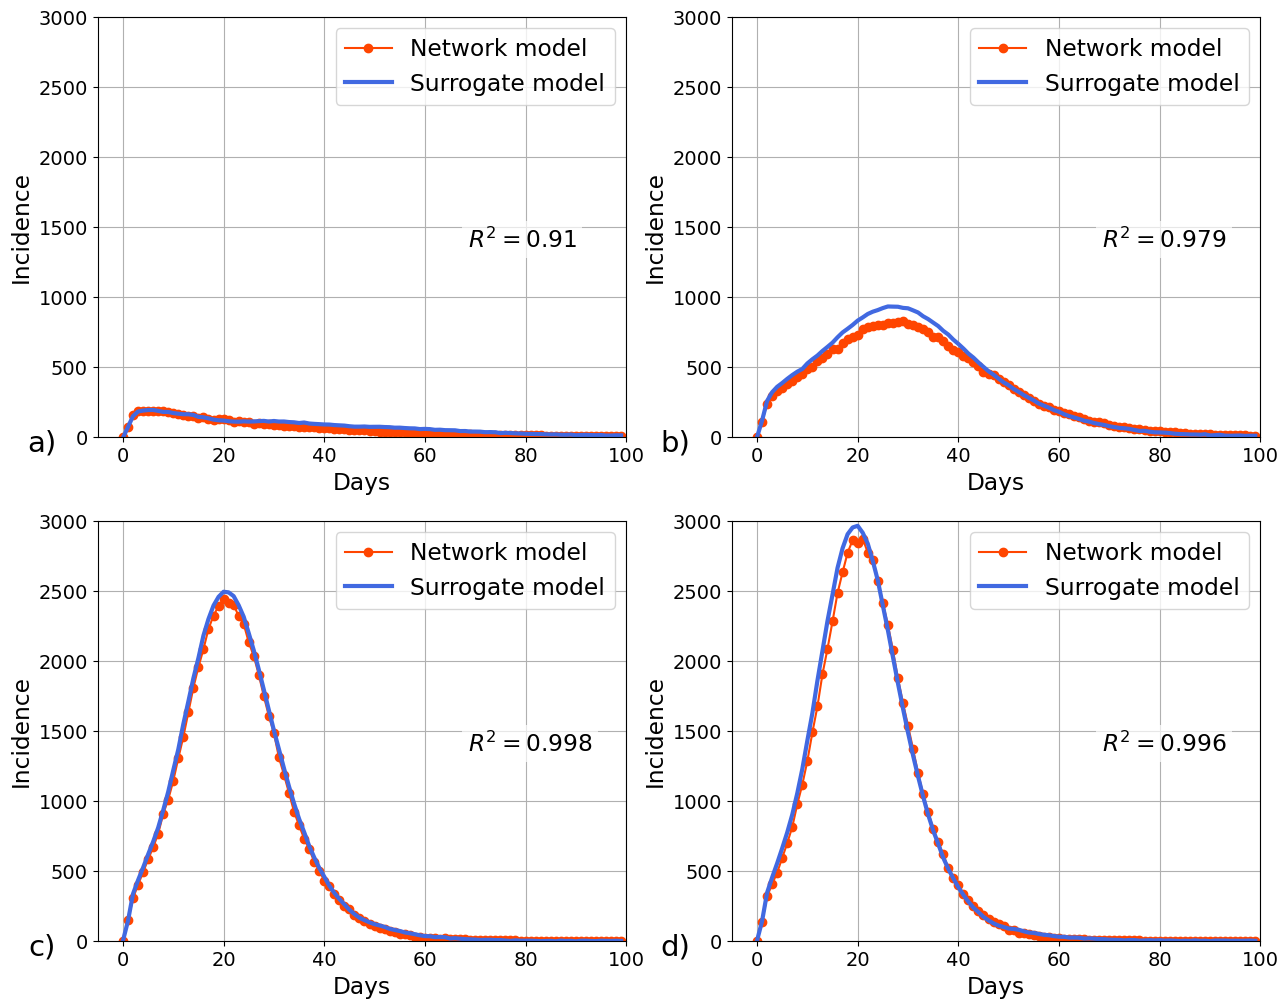

In [16]:
fontsize = 14
test_indices = [11,7,1,15]
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(15, 12))

labels = ['a)', 'b)', 'c)', 'd)']
counter = 0
cut = 100
for row in range(rows):
    for col in range(cols):
        surrogate_sim = predict(ae, X_test[test_indices[counter]]).numpy()
        r2 = r2_score(y_test[test_indices[counter]], surrogate_sim)
        
        ax[row][col].plot(y_test[test_indices[counter]][:cut], label='Network model', marker='o', color='OrangeRed')
        ax[row][col].plot(surrogate_sim[:cut], lw=3, color='RoyalBlue', label='Surrogate model')

        ax[row][col].set_xlabel('Days', fontsize=1.2*fontsize)
        ax[row][col].set_ylabel('Incidence', fontsize=1.2*fontsize)
        ax[row][col].set_ylim(0, 3000)
        ax[row][col].set_xlim(-5, 100)
        ax[row][col].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[row][col].legend(fontsize=1.2*fontsize)
        ax[row][col].grid()
        # ax[row][col].set_title(r'$R^2={}$'.format(round(r2, 3)), fontsize=1.2*fontsize)
        
        # Add subplot label outside the top-left corner
        ax[row][col].annotate(labels[counter], xy=(0, 0), xycoords='axes fraction',
                              xytext=(-30, -10), textcoords='offset points',
                              fontsize=1.5*fontsize, ha='right', va='baseline')
        ax[row][col].text(0.7, 0.5, r'$R^2={}$'.format(round(r2, 3)), transform=ax[row][col].transAxes,
                          fontsize=1.2*fontsize, verticalalignment='top',
                          bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        counter += 1


fig.savefig(r'ae_{}_mean_network_subplots_point_estimation_n.pdf'.format(network_type), bbox_inches='tight')
fig.savefig(r'ae_{}_mean_network_subplots_point_estimation_n.png'.format(network_type), dpi=600, bbox_inches='tight')


#### AE Colormap

In [17]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(ae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

In [18]:
import time

val = 0
for index in range(1000):
    start = time.time()
    predict(ae, X_test[index])
    end = time.time()
    val += end - start
print(val/1000)

0.00021126818656921388


In [19]:
np.mean(R2_test)

np.float64(0.9034961682061354)

In [20]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x**4

# Get plasma colormap and create nonlinear version
plasma = plt.cm.RdYlGn
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)


In [21]:
import seaborn as sns


In [22]:
dd = pd.DataFrame(heatmap)
dd.columns = np.arange(0.1, 1., 0.01).round(2)
dd.index = np.arange(0.2, 1., 0.01).round(2)
dd.sort_index(level=1, ascending=False)

,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0.99,0.988384,NaN,0.994495,0.998656,NaN,0.999616,NaN,NaN,NaN,0.998834,...,NaN,NaN,0.998839,0.997826,NaN,NaN,NaN,NaN,0.997813,NaN
0.98,NaN,NaN,NaN,0.999662,NaN,0.998573,0.996946,NaN,NaN,0.996451,...,NaN,NaN,0.999256,NaN,0.999573,0.999488,NaN,0.999427,0.999530,NaN
0.97,NaN,0.999441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.999598,0.999493,0.999655,NaN,NaN,NaN
0.96,NaN,0.997376,NaN,NaN,NaN,0.998660,NaN,0.999369,NaN,NaN,...,0.999336,NaN,0.999348,NaN,NaN,0.998967,NaN,0.999703,NaN,NaN
0.95,0.997914,NaN,NaN,0.998724,NaN,NaN,0.998258,NaN,NaN,NaN,...,NaN,0.999185,NaN,0.998982,NaN,NaN,NaN,0.998958,NaN,0.99927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.24,NaN,-0.150787,NaN,NaN,0.013879,NaN,NaN,0.209828,NaN,0.266418,...,NaN,NaN,NaN,0.883376,0.863664,NaN,NaN,NaN,NaN,NaN
0.23,NaN,NaN,NaN,NaN,0.004192,NaN,NaN,NaN,NaN,NaN,...,NaN,0.836156,NaN,0.871843,0.878994,0.871467,NaN,0.890100,NaN,NaN
0.22,NaN,NaN,NaN,NaN,-0.016919,NaN,NaN,NaN,0.245633,NaN,...,NaN,0.865122,NaN,NaN,NaN,NaN,0.846722,0.847353,0.846072,NaN
0.21,NaN,NaN,NaN,NaN,-0.060704,0.017013,NaN,0.141346,0.189466,0.208628,...,NaN,NaN,NaN,NaN,0.871812,NaN,NaN,0.824205,NaN,NaN


In [23]:
def plot_test_with_intervals(params, gt, fontsize=14):
    gt = np.array(gt)
    mean_index = range(tmax)
    low_index = range(tmax, 2*tmax)
    high_index = range(2*tmax, 3*tmax)
    surrogate_sim = predict(ae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt[mean_index], label='Network model', marker='o', color='OrangeRed')
    ax.fill_between(np.linspace(0, tmax, tmax), gt[low_index], gt[high_index],
                    alpha = 0.5, color='OrangeRed', label='Network model interval')
    ax.plot(surrogate_sim[mean_index], lw=3, color='RoyalBlue', label='Surrogate model')
    ax.fill_between(np.linspace(0, tmax, tmax), 
                    surrogate_sim[low_index], 
                    surrogate_sim[high_index],
                    alpha = 0.5, color='RoyalBlue', label='Surrogate model interval')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            
            loss = criterion(pred, y_batch.to(device))

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def interval_ae_loss(pred, target, theta_1=1.0, theta_2=1.0, theta_3=1.0):
    """
    Custom loss for interval-aware autoencoder.
    """
    # Split the prediction into mean, lower bound, upper bound
    mean_pred, lb_pred, ub_pred = torch.chunk(pred, 3, dim=1)

    # Squeeze last dimension if needed
    mean_pred = mean_pred.squeeze(-1)
    # print(mean_pred.size())
    lb_pred = lb_pred.squeeze(-1)
    ub_pred = ub_pred.squeeze(-1)
    # Ensure target shape matches
    target = target.squeeze(-1) if target.ndim == 2 else target

    # print(target.size())

    # Mean squared error for the mean prediction
    mean_loss = torch.nn.functional.mse_loss(pred, target)

    # Bound loss
    bound_loss = torch.mean(torch.relu(lb_pred - mean_pred) + torch.relu(mean_pred - ub_pred))

    # Interval constraint loss
    interval_loss = torch.mean(torch.relu(lb_pred - ub_pred))

    total_loss = theta_1 * mean_loss + theta_2 * bound_loss + theta_3 * interval_loss
    return total_loss


In [24]:
# Saving 
# torch.save(ae, '../models/autoencoder_interval_barabasi_100k.pt')

# Loading
ae = torch.load('../models/autoencoder_interval_barabasi_100k_n.pt', weights_only=False)
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=450, bias=True)
  )
)

In [25]:
R2_test = []
R2_mean = []
R2_min = []
R2_high = []

for index, params in enumerate(X_test):
    prediction = predict(ae, params)
    R2_test.append(r2_score(prediction, y_test[index]))
    R2_mean.append(r2_score(prediction[:tmax], y_test[index][:tmax]))
    R2_min.append(r2_score(prediction[tmax:tmax*2], 
                           y_test[index][tmax:tmax*2]))
    R2_high.append(r2_score(prediction[tmax*2:tmax*3], 
                            y_test[index][tmax*2:tmax*3]))
    
np.mean(R2_test),np.mean(R2_mean),np.mean(R2_min),np.mean(R2_high)

ValueError: Found input variables with inconsistent numbers of samples: [450, 150]

In [ ]:
prediction.shape

In [ ]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap2 = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap2[i, j] = r2
dd2 = pd.DataFrame(heatmap2)
dd2.columns = np.arange(0.1, 1., 0.01).round(2)
dd2.index = np.arange(0.2, 1., 0.01).round(2)
dd2.sort_index(level=1, ascending=False)   

heatmap_mean = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_mean):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap_mean[i, j] = r2
dd2_mean = pd.DataFrame(heatmap_mean)
dd2_mean.columns = np.arange(0.1, 1., 0.01).round(2)
dd2_mean.index = np.arange(0.2, 1., 0.01).round(2)
dd2_mean.sort_index(level=1, ascending=False)  

heatmap_min = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_min):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap_min[i, j] = r2
dd2_min = pd.DataFrame(heatmap_min)
dd2_min.columns = np.arange(0.1, 1., 0.01).round(2)
dd2_min.index = np.arange(0.2, 1., 0.01).round(2)
dd2_min.sort_index(level=1, ascending=False)  

heatmap_high = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_high):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap_high[i, j] = r2
dd2_high = pd.DataFrame(heatmap_high)
dd2_high.columns = np.arange(0.1, 1., 0.01).round(2)
dd2_high.index = np.arange(0.2, 1., 0.01).round(2)
dd2_high.sort_index(level=1, ascending=False)  
'''
# Mask X_train locations
train_mask = np.zeros_like(heatmap2, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True
'''        


In [ ]:
fontsize = 14
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
ax=axes.flatten()

n = ['a)','b)','c)','d)'][::-1]


cmap = nonlinear_cmap

ax_1 = sns.heatmap(dd.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[0], #norm=norm, 
                   cbar_kws={'extendfrac': .1,
                            #"ticks":ticks, "boundaries":boundaries
                            },
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_1.set_title('Point estimation', 
               fontsize=1.2*fontsize)
colorbar = ax_1.collections[0].colorbar

ax_2 = sns.heatmap(dd2_mean.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[1], #norm=norm, 
                   cbar_kws={'extendfrac': .1},
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_2.set_title('Interval estimation (mean)', 
               fontsize=1.2*fontsize)
colorbar = ax_2.collections[0].colorbar

ax_3 = sns.heatmap(dd2_min.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[2], #norm=norm, 
                   cbar_kws={'extendfrac': .1},
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_3.set_title('Interval estimation (lower bound)', 
               fontsize=1.2*fontsize)
colorbar = ax_3.collections[0].colorbar

ax_4 = sns.heatmap(dd2_high.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[3], #norm=norm, 
                   cbar_kws={'extendfrac': .1},
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_4.set_title('Interval estimation (upper bound)', 
               fontsize=1.2*fontsize)
colorbar = ax_4.collections[0].colorbar

for ax_i in [ax_1, ax_2,ax_3, ax_4]:
    ax_i.text(-0.1, 1.1, n.pop(),
              transform=ax_i.transAxes, size=1.5*fontsize)
    ax_i.collections[0].cmap.set_bad('0.7')
    ax_i.set_xlabel(r'$\beta_n$', fontsize=1.2*fontsize)
    ax_i.set_ylabel(r'$\alpha$', fontsize=1.2*fontsize)
    ax_i.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar = ax_i.collections[0].colorbar
    cbar.set_label(r'$R^2$', rotation=0, size=fontsize)
        
for i in [-1,-2]:    
    ax_1.figure.axes[i].tick_params(labelsize=fontsize)

#ax_1.figure.axes[-1].set_ylabel(r'$R^2$', size=fontsize)
#ax_1.figure.axes[-2].set_ylabel(r'$R^2$', size=fontsize)

plt.tight_layout()
fig.savefig(r'../figures/ae_mean_ba_colormap_n.png', dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_mean_ba_colormap_n.pdf', dpi=600, bbox_inches='tight')

# old

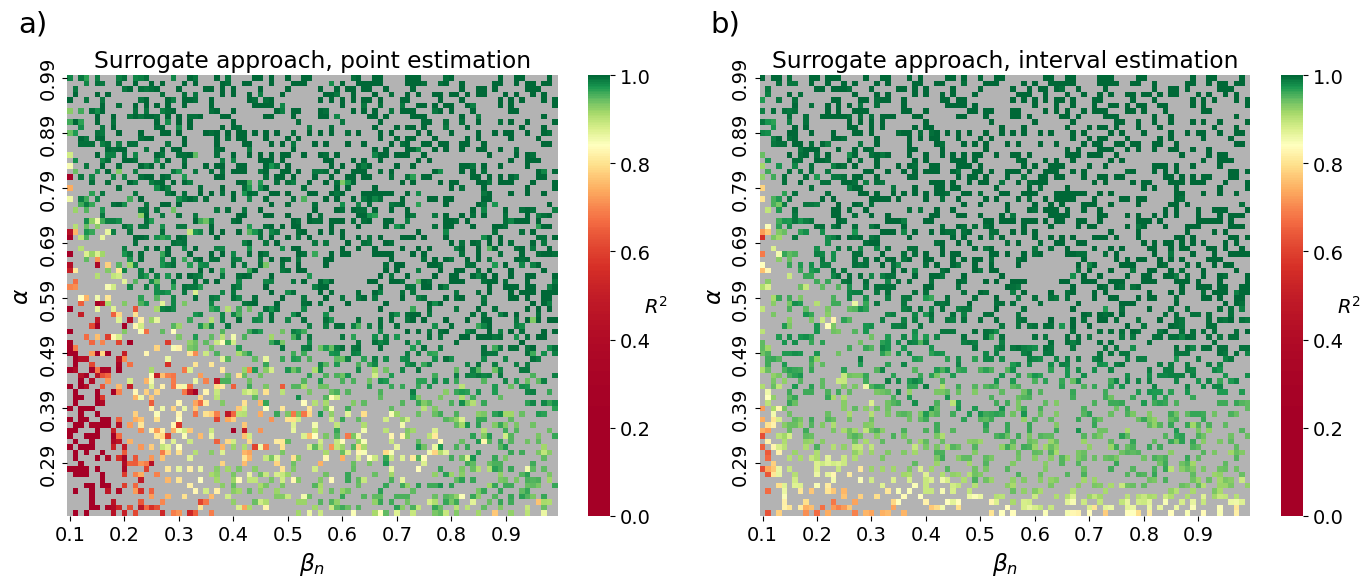

In [141]:
fontsize = 14
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax=axes.flatten()

n = ['a)','b)'][::-1]


cmap = nonlinear_cmap


ax_1 = sns.heatmap(dd.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[0], #norm=norm, 
                   cbar_kws={'extendfrac': .1,
                            #"ticks":ticks, "boundaries":boundaries
                            },
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_1.set_title('Surrogate approach, point estimation', 
               fontsize=1.2*fontsize)

colorbar = ax_1.collections[0].colorbar

ax_2 = sns.heatmap(dd2.sort_index(level=1, ascending=False), 
                   cmap=cmap, ax=ax[1], #norm=norm, 
                   cbar_kws={'extendfrac': .1},
                   vmin=0, vmax=1,
                  xticklabels = 10, yticklabels=10,
                  linewidths=0.0, rasterized=True,)
ax_2.set_title('Surrogate approach, interval estimation', 
               fontsize=1.2*fontsize)

colorbar = ax_2.collections[0].colorbar


for ax_i in [ax_1, ax_2]:
    ax_i.text(-0.1, 1.1, n.pop(),
              transform=ax_i.transAxes, size=1.5*fontsize)
    ax_i.collections[0].cmap.set_bad('0.7')
    ax_i.set_xlabel(r'$\beta_n$', fontsize=1.2*fontsize)
    ax_i.set_ylabel(r'$\alpha$', fontsize=1.2*fontsize)
    ax_i.tick_params(axis='both', which='major', labelsize=fontsize)
    cbar = ax_i.collections[0].colorbar
    cbar.set_label(r'$R^2$', rotation=0, size=fontsize)
        
for i in [-1,-2]:    
    ax_1.figure.axes[i].tick_params(labelsize=fontsize)

#ax_1.figure.axes[-1].set_ylabel(r'$R^2$', size=fontsize)
#ax_1.figure.axes[-2].set_ylabel(r'$R^2$', size=fontsize)

plt.tight_layout()
fig.savefig(r'../figures/ae_colormap_n.png', dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_colormap_n.pdf', dpi=600, bbox_inches='tight')

In [19]:
batch = next(iter(train_loader))
print(batch[0].size())
yhat = ae(batch[0])

torch.Size([16, 2])


In [31]:
def plot_test(params, gt, fontsize=14):
    surrogate_sim = predict(ae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt, label='Network model', marker='o', color='OrangeRed')
    # ax.plot(surrogate_sim, lw=3, color='RoyalBlue', label='Surrogate model')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.set_ylim(0, 1500)
    ax.set_xlim(-5, 150)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    # ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

In [21]:
for _ in range(len(y_test)):
    index = random.randint(0, len(y_test))
    index = _
    if abs(X_test[index][0] - 0.7) < 0.1 and \
        abs(X_test[index][1] - 0.8) < 0.1 and max(y_test[index]) < 1500:
        fig = plot_test(X_test[index], y_test[index])
        fig.savefig(r'network_ba_simulation_{}.png'.format(index), 
                    dpi=600, bbox_inches='tight')
        fig.savefig(r'network_ba_simulation_{}.pdf'.format(index), 
                    bbox_inches='tight')
        print(X_test[index])
        print(index)
        break

In [22]:
for index in [26, 19, 511]:
    fig = plot_test(X_test[index], y_test[index])
    fig.savefig(r'network_ba_simulation_{}.png'.format(index), 
                dpi=600, bbox_inches='tight')
    fig.savefig(r'network_ba_simulation_{}.pdf'.format(index), 
                bbox_inches='tight')
    print(X_test[index])

NameError: name 'vae' is not defined

### Variational autoencoder

In [23]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

def warmup_loss(epoch, n_epochs, criterion, steps, pred, mu, logvar, gt, use=True):
    if use:
        if epoch/n_epochs < steps:
            loss = criterion(pred ,gt)
        else:
            mse_loss = criterion(pred, gt)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse_loss + kl_loss
    else:
        loss = criterion(pred, gt)

    return loss

def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred, _, _ = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    tb = SummaryWriter()

    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred, mu, logvar = model(X_batch.to(device))

            loss = warmup_loss(epoch, n_epochs, criterion, 0, pred, mu, logvar, y_batch.to(device), use=True)

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

        tb.add_scalar("Total loss", loss.item(), epoch)
    tb.close()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
hidden_size = 512
latent_size = 256
n_epochs = 100

mse_cr = F.mse_loss
r2_cr = r2_loss
vae = VariationalAutoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=5e-4)

In [27]:
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

In [28]:
train(vae, n_epochs, train_loader, mse_cr, optimizer, lr_sched)

100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


In [29]:
test(vae, X_test, y_test)

R2 Score: 0.8851743287560514


In [19]:
def plot_test(params, gt, fontsize=14):
    surrogate_sim = predict(vae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt, label='Network model', marker='o', color='OrangeRed')
    ax.plot(surrogate_sim, lw=3, color='RoyalBlue', label='Surrogate model')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

In [20]:
for _ in range(30):
    index = random.randint(0, len(y_test))
    fig = plot_test(X_test[index], y_test[index])
    fig.savefig(r'surrogate_network_model_comparison_{}.png'.format(index), 
                dpi=600, bbox_inches='tight')

NameError: name 'vae' is not defined

In [21]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(vae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

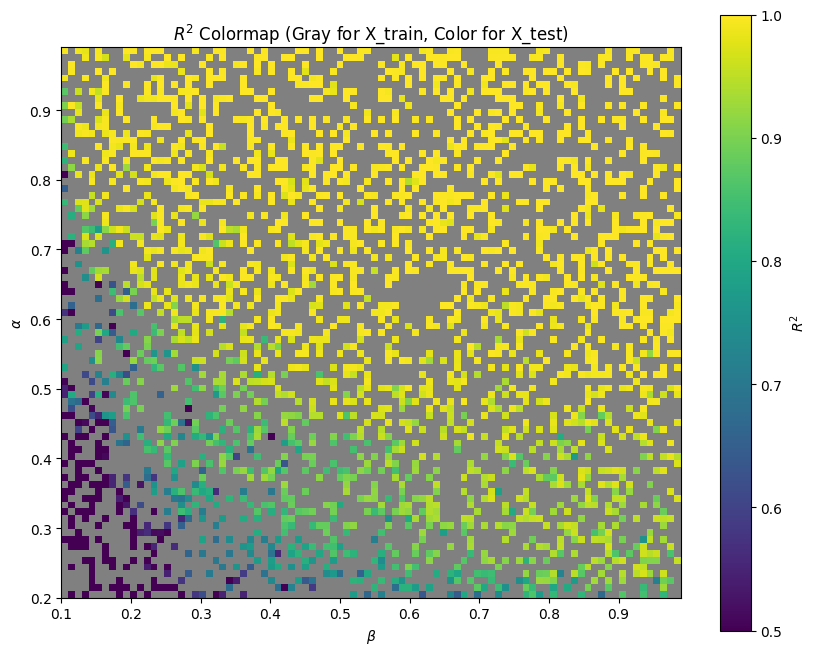

In [22]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.viridis.copy()
cmap.set_bad('gray')  # train in gray
img = plt.imshow(masked_heatmap, origin='lower', cmap=cmap, vmin=0.5, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]])
plt.colorbar(img, label='$R^2$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
plt.savefig('../figures/colomap_network_autoencoder.png', dpi=600, bbox_inches='tight')

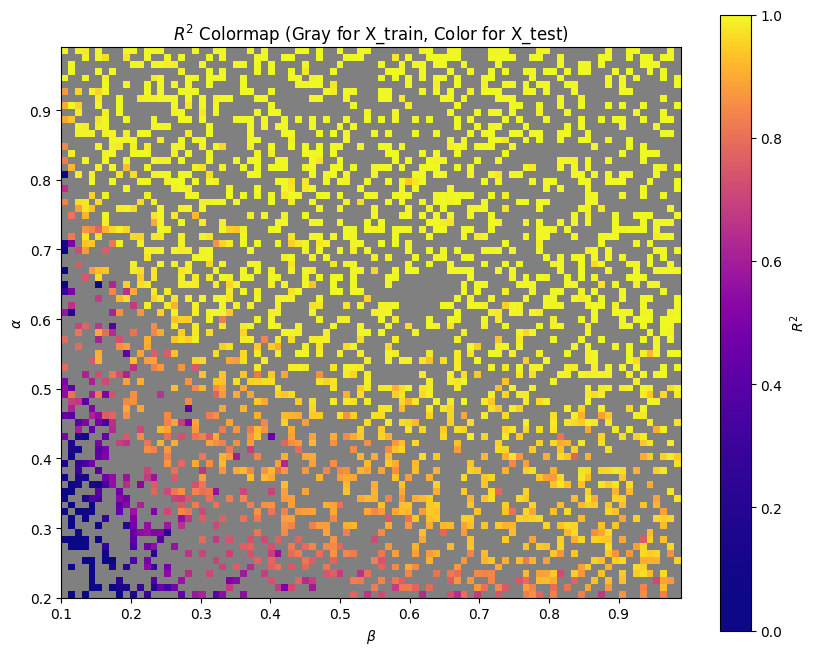

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x**2

# Get plasma colormap and create nonlinear version
plasma = plt.cm.plasma
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)

# Plot
plt.figure(figsize=(10, 8))
nonlinear_cmap.set_bad('gray')  # train in gray
img = plt.imshow(masked_heatmap, origin='lower', cmap=nonlinear_cmap, vmin=0, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]])
plt.colorbar(img, label='$R^2$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
plt.savefig('../figures/colomap_network_autoencoder.png', dpi=600, bbox_inches='tight')